# Challenge - 4rd scenery

In this notebook, it will be proposed an complete architecture to the scenery proposed in challenge 3. There will be covered the steps involved on the model ops, since data storage until model and application deployment. The tools covered in this document will be opensource, since an opensource solution is available. The architecture will be based on AWS, but it can be implemented in any other cloud service. For workflow orchestration, [Flyte](https://flyte.org) will be proposed. Model deployment will be achieved using [BentoML](https://www.bentoml.com/)'s Yatai, an opensource tool to be used in the Kubernetes cluster.

## 1. Data storage

To storage model data, i.e. the images that will be used for model training, it could be used an S3 bucket, with `day` and `night` folders, through human curation. Model versions can be saved using an MLFlow instance, as artifact format. Then, model versioning will be available, granting reliability.

## 2. Model training and Deployment

Training can be done through an pipeline orchestration tool, such as Apache Airflow. In this solution, it is proposed to use Flyte, an open source workflow orchestration based on kubernetes, where each step of the process can be created as a task that runs in a isolated and independent pod, providing more eficiency, scalability and safety for all the process. Flyte will be deployed in EKS using a helm chart and a Terraform instance could handle with needed permissions. Then, there will be the following tasks:
* Dataset preprocessing, where the stored images will be transformed to required sizes;
* Feature extraction, to get mean RGB and brightness intensities and create an customized dataset for model training input;
* Model training, alongside with MLFlow for model versioning;
* Model deployment using BentoML's Yatai integration. This will grant us model deployment with easy operation and salability relying on the Kubernetes cluster, as well as some cluster and pod metrics. Another option could be AWS SageMaker model deployment with an Lambda function setted to receive an API Gateway input and perform classification.

## 3. Application

For usability criteria, it will be needed an interface that allow users to upload an image to predict if it is day or night scenario. In this regard, a simple app can be done using Streamlit, and the deploy made by creating an Docker image with the application, upload it to AWS ECS, and deploy it in the cluster. Uploaded images can be added to the S3 bucket and added to the corresponded folder later on, if needed.

## 4. Model monitoring

To evaluate model metrics such as model drift, [whylogs](https://github.com/whylabs/whylogs) can be integrated to MLFlow to extract and show these metrics in a readable format.

## 5. Architecture diagram

In [1]:
%pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.4/24.4 MB 50.7 kB/s eta 0:00:0000:0100:10
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 75.4 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 76.8 kB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for typed-ast<2.0.0,>=1.5.4 from https://files.pythonhosted.org/packages/31/f3/38839df509b04fb54205e388fc04b47627377e0ad628870112086864a441/typed_ast-1.5.5-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.0/840.0 kB 65.8 kB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


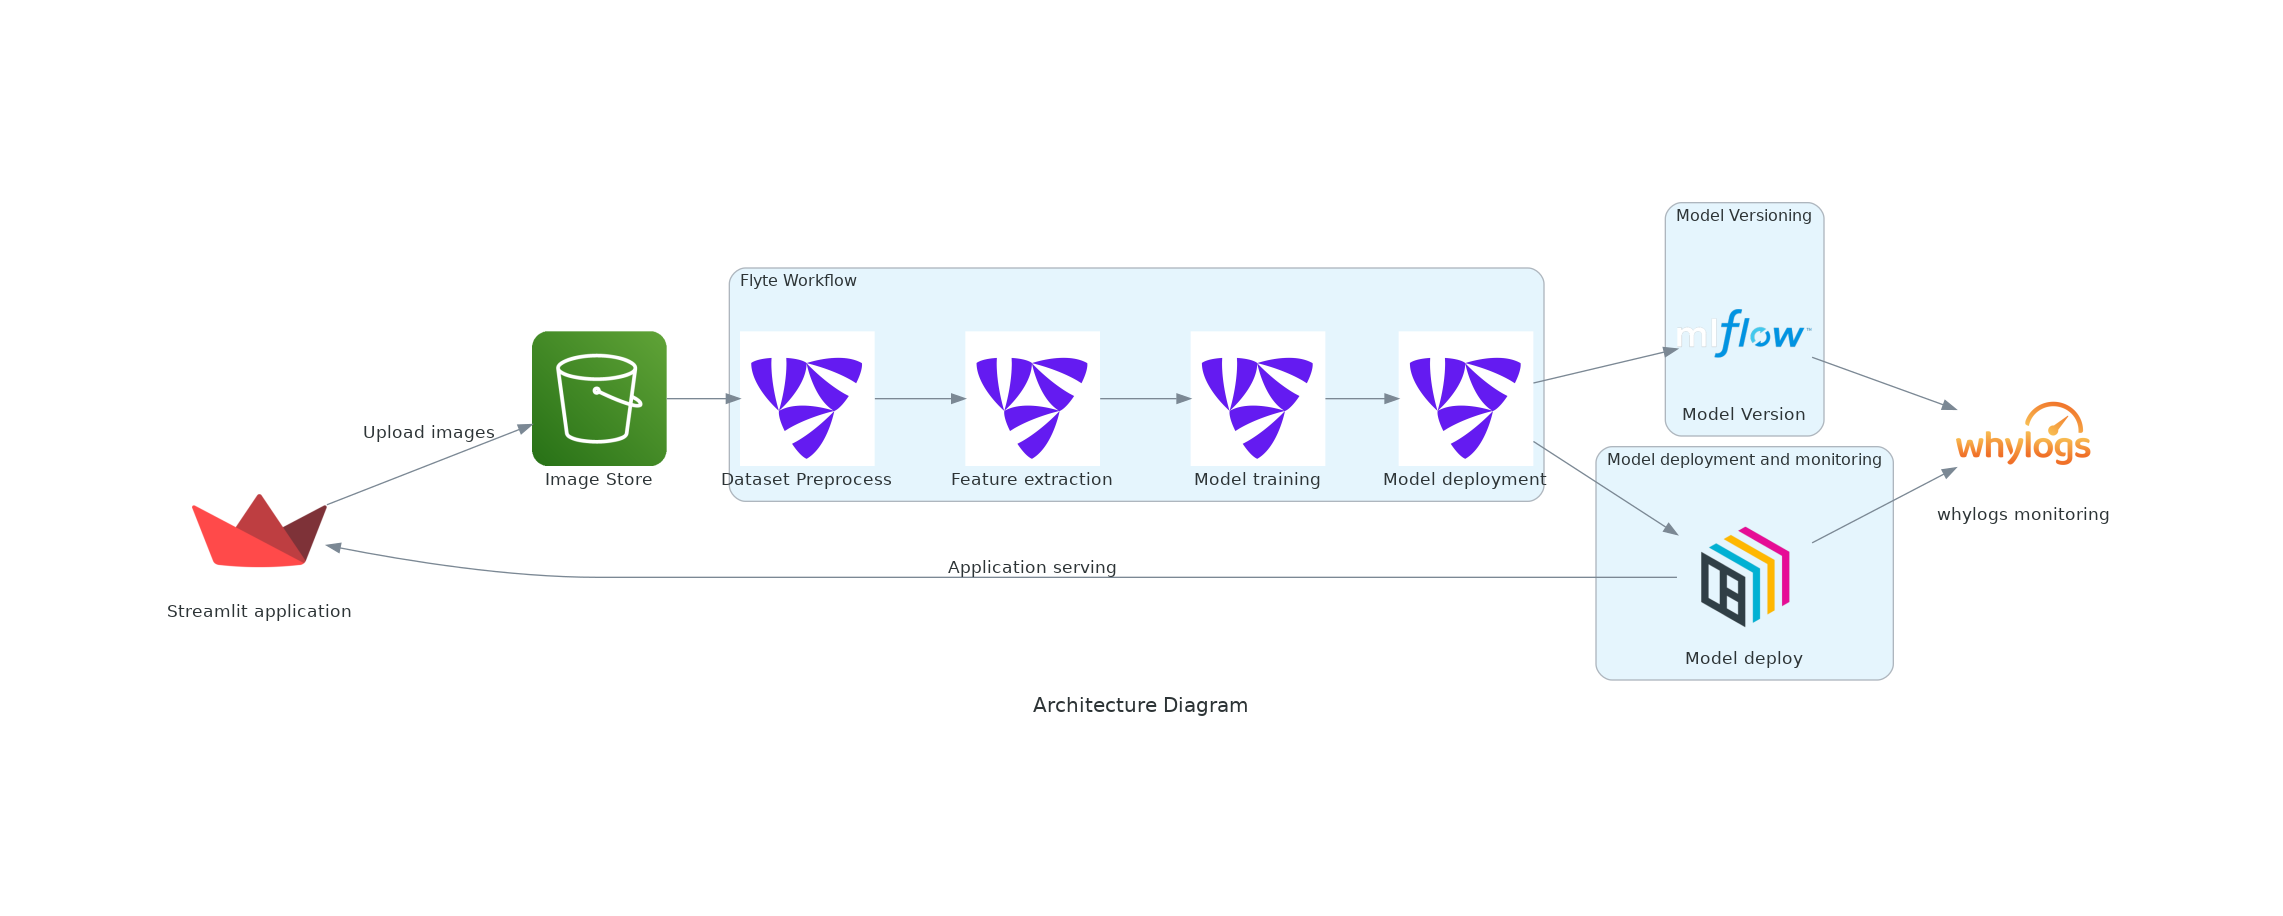

Try running the update-desktop-database command. If you
don't have this command you should install the
desktop-file-utils package. This package is available from
http://freedesktop.org/wiki/Software/desktop-file-utils/
No applications found for mimetype: image/png
./usr/bin/xdg-open: 882: x-www-browser: not found
/usr/bin/xdg-open: 882: firefox: not found
/usr/bin/xdg-open: 882: iceweasel: not found
/usr/bin/xdg-open: 882: seamonkey: not found
/usr/bin/xdg-open: 882: mozilla: not found
/usr/bin/xdg-open: 882: epiphany: not found
/usr/bin/xdg-open: 882: konqueror: not found
/usr/bin/xdg-open: 882: chromium: not found
/usr/bin/xdg-open: 882: chromium-browser: not found
/usr/bin/xdg-open: 882: google-chrome: not found
/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method avai

In [80]:
from diagrams import Diagram, Cluster, Edge
from diagrams.aws.compute import EKS
from diagrams.aws.storage import S3
from diagrams.custom import Custom
from diagrams.onprem.mlops import Mlflow

flyte_image_path = "./diagram_resources/flyte.jpg"
bento_image_path = "./diagram_resources/bentoml.png"
streamlit_image_path = "./diagram_resources/streamlit.png"
whylogs_image_path = "./diagram_resources/whylogs.png"

with Diagram("Architecture Diagram", direction="LR", graph_attr={"splines": "spline"}) as diag:
    store = S3("Image Store")
    with Cluster("Flyte Workflow", direction="TB", graph_attr={}):
        dataset_preprocess = Custom("Dataset Preprocess", flyte_image_path)
        feat_extraction = Custom("Feature extraction", flyte_image_path)
        model_train = Custom("Model training", flyte_image_path)
        model_deploy = Custom("Model deployment", flyte_image_path)

        dataset_preprocess >> feat_extraction >> model_train >> model_deploy
    
    store >> dataset_preprocess

    with Cluster("Model Versioning"):
        version = Mlflow("Model Version")
        
        model_deploy >> version

    with Cluster("Model deployment and monitoring"):
        deploy = Custom("Model deploy", bento_image_path)
        
        model_deploy >> deploy


    serving = Custom("Streamlit application", streamlit_image_path)
    
    deploy >> Edge(label="Application serving", labelloc="b") >> serving
    serving >> Edge(label="Upload images", labelloc="b") >> store

    metrics = Custom("whylogs monitoring", whylogs_image_path)

    deploy >> metrics
    version >> metrics
    

diag